In [50]:
import pandas as pd

In [51]:
df = pd.read_csv('global_power_plant_database.csv')

In [52]:
df.head(5)

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,url,geolocation_source,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.00,32.3220,65.1190,Hydro,NaN,NaN,...,http://globalenergyobservatory.org,GEODB,1009793,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.00,34.5560,69.4787,Hydro,NaN,NaN,...,http://globalenergyobservatory.org,GEODB,1009795,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.00,34.6410,69.7170,Hydro,NaN,NaN,...,http://globalenergyobservatory.org,GEODB,1009797,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,Nangarhar (Darunta) Hydroelectric Power Plant ...,GEODB0040536,11.55,34.4847,70.3633,Hydro,NaN,NaN,...,http://globalenergyobservatory.org,GEODB,1009787,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,Northwest Kabul Power Plant Afghanistan,GEODB0040540,42.00,34.5638,69.1134,Gas,NaN,NaN,...,http://globalenergyobservatory.org,GEODB,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Install required packages
!pip install mlflow==2.8.0
!pip install xgboost
!pip install seaborn matplotlib scikit-learn pandas numpy tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully u

^C


In [37]:
import pandas as pd
import numpy as np
import mlflow
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [56]:
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset dimensions: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    print("\nMissing values summary:")
    print(pd.DataFrame({'Missing Count': missing_values,
                        'Missing Percentage': missing_percentage})[missing_values > 0])
    df_clean = df.copy()

    df_clean['commissioning_year'] = df_clean['commissioning_year'].fillna(
        df_clean['commissioning_year'].median())
    df_clean['capacity_mw'] = df_clean['capacity_mw'].fillna(df_clean['capacity_mw'].median())
    for coord in ['latitude', 'longitude']:
        country_medians = df_clean.groupby('country')[coord].median().to_dict()
        mask = df_clean[coord].isna()
        df_clean.loc[mask, coord] = df_clean.loc[mask, 'country'].map(country_medians)
        df_clean[coord] = df_clean[coord].fillna(df_clean[coord].median())

    df_clean['plant_age'] = 2018 - df_clean['commissioning_year']

    df_clean['dist_from_equator'] = df_clean['latitude'].abs()
    df_clean['coastal_region'] = (
        (df_clean['dist_from_equator'] < 60) &
        (
            (df_clean['longitude'] > 165) | (df_clean['longitude'] < -150) |
            ((df_clean['longitude'] > -20) & (df_clean['longitude'] < 50)) |
            ((df_clean['longitude'] > 100) & (df_clean['longitude'] < 150))
        )
    ).astype(int)

    df_clean['is_multi_fuel'] = (~df_clean['other_fuel1'].isna()).astype(int)

    df_clean['primary_fuel'] = df_clean['primary_fuel'].fillna('Unknown')

    fuel_counts = df_clean['primary_fuel'].value_counts()
    rare_fuels = fuel_counts[fuel_counts < len(df_clean) * 0.01].index
    df_clean['primary_fuel_grouped'] = df_clean['primary_fuel'].apply(
        lambda x: 'Other' if x in rare_fuels else x)

    country_stats = df_clean.groupby('country').agg({
        'capacity_mw': ['mean', 'median', 'count'],
        'commissioning_year': 'mean'
    })
    country_stats.columns = ['country_avg_capacity', 'country_median_capacity',
                             'country_plant_count', 'country_avg_year']
    df_clean = df_clean.merge(country_stats, left_on='country', right_index=True)

    df_clean['capacity_relative_to_country'] = df_clean['capacity_mw'] / df_clean['country_avg_capacity']

    country_counts = df_clean['country'].value_counts()
    small_countries = country_counts[country_counts < len(df_clean) * 0.01].index
    df_clean['country_grouped'] = df_clean['country'].apply(
        lambda x: 'Other' if x in small_countries else x)

    # Drop features with very low correlation to capacity_mw
    # Based on the correlation data provided, we drop:
    #   plant_age, latitude, country_plant_count, dist_from_equator
    df_clean = df_clean.drop(columns=['plant_age','country_plant_count', 'dist_from_equator'])

    # Visualizations
    print("\nCreating data visualizations...")
    plt.figure(figsize=(12, 6))
    plt.hist(np.log1p(df_clean['capacity_mw']), bins=50)
    plt.title('Distribution of Plant Capacity (Log Scale)')
    plt.xlabel('Log(Capacity + 1) (MW)')
    plt.ylabel('Count')
    plt.savefig('capacity_distribution.png')

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='primary_fuel_grouped', y=np.log1p(df_clean['capacity_mw']), data=df_clean)
    plt.title('Capacity by Fuel Type (Log Scale)')
    plt.xlabel('Primary Fuel')
    plt.ylabel('Log(Capacity + 1) (MW)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('capacity_by_fuel.png')

    plt.figure(figsize=(12, 6))
    plt.scatter(df_clean['coastal_region'], np.log1p(df_clean['capacity_mw']), alpha=0.3)
    plt.title('Capacity vs Coastal Region (Binary)')
    plt.xlabel('Coastal Region (0=No, 1=Yes)')
    plt.ylabel('Log(Capacity + 1) (MW)')
    plt.savefig('capacity_vs_coastal.png')

    print("Data preparation complete!")
    return df_clean

def prepare_for_modeling(df):
    from sklearn.model_selection import train_test_split
    categorical_features = ['primary_fuel_grouped', 'country_grouped']
    numerical_features = ['country_avg_capacity', 'longitude', 'is_multi_fuel', 'coastal_region']

    # Target variable remains capacity_mw
    y = df['capacity_mw']
    X = df[categorical_features + numerical_features]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test


In [55]:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.svm import SVR
    import xgboost as xgb
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    import mlflow
    import mlflow.sklearn
    import mlflow.tensorflow
    from mlflow.models.signature import infer_signature

In [60]:
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

def plot_predictions(model, X_test, y_test, model_name):
    import matplotlib.pyplot as plt

    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual Capacity (MW)')
    plt.ylabel('Predicted Capacity (MW)')
    plt.title(f'{model_name}: Predicted vs Actual Capacity')
    plt.tight_layout()
    plot_path = f"plots/{model_name}_predictions.png"
    plt.savefig(plot_path)
    plt.close()
    return plot_path

def log_feature_importance(model, feature_names, model_name):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 8))

    try:
        if hasattr(model, 'feature_importances_'):
            # For tree-based models
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            plt.bar(range(len(importances)), importances[indices])
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            plt.title(f'Feature Importance - {model_name}')
            plt.tight_layout()
            importance_path = f"plots/{model_name}_feature_importance.png"
            plt.savefig(importance_path)
            plt.close()
            return importance_path
        elif hasattr(model, 'coef_'):
            # For linear models
            coeffs = model.coef_
            if len(coeffs.shape) == 1:  # Simple linear models
                plt.bar(range(len(coeffs)), coeffs)
                plt.xticks(range(len(coeffs)), feature_names, rotation=90)
                plt.title(f'Feature Coefficients - {model_name}')
                plt.tight_layout()
                coef_path = f"plots/{model_name}_coefficients.png"
                plt.savefig(coef_path)
                plt.close()
                return coef_path
    except:
        pass

    plt.close()
    return None

def prepare_data(df):

    df_ml = df.copy()

    df_ml['commissioning_year'] = df_ml['commissioning_year'].fillna(df_ml['commissioning_year'].median())

    y = df_ml['capacity_mw']
    df_ml['plant_age'] = 2018 - df_ml['commissioning_year']

    df_ml['dist_from_equator'] = df_ml['latitude'].abs()

    df_ml['is_multi_fuel'] = (~df_ml['other_fuel1'].isna()).astype(int)
    categorical_features = ['primary_fuel', 'country']
    numerical_features = ['plant_age', 'latitude', 'longitude', 'dist_from_equator', 'is_multi_fuel']

    X = df_ml[categorical_features + numerical_features]

    return X, y

def create_preprocessing_pipeline(X):
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    categorical_features = ['primary_fuel', 'country']
    numerical_features = [col for col in X.columns if col not in categorical_features]

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, numerical_features, categorical_features

from tqdm import tqdm

def run_power_plant_experiments(df):
    os.makedirs("plots", exist_ok=True)

    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    preprocessor, numerical_features, categorical_features = create_preprocessing_pipeline(X)

    preprocessor.fit(X_train)

    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        encoder = preprocessor.transformers_[1][1].named_steps['onehot']
        cat_feature_names.extend([f"{category}_{cat_val}" for cat_val in encoder.get_feature_names_out()])

    all_feature_names = numerical_features + cat_feature_names

    models = {
        "Linear_Regression": LinearRegression(),
        "Ridge_Regression": Ridge(),
        "Lasso_Regression": Lasso(),
        "ElasticNet": ElasticNet(),
        "Random_Forest": RandomForestRegressor(random_state=42),
        "Gradient_Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42),
        "SVR": SVR()
    }

    param_grids = {
        "Linear_Regression": {},
        "Ridge_Regression": {'alpha': [0.1, 1.0, 10.0]},
        "Lasso_Regression": {'alpha': [0.1, 1.0, 10.0]},
        "ElasticNet": {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]},
        "Random_Forest": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "Gradient_Boosting": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        },
        "XGBoost": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        },
        "SVR": {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    }

    for model_name in tqdm(models, desc="Model Experiments"):
        model = models[model_name]
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_type", model_name)
            param_grid = param_grids[model_name]

            if param_grid:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])
                grid_search = GridSearchCV(
                    pipeline,
                    param_grid={f"model__{param}": values for param, values in param_grid.items()},
                    cv=5,
                    scoring='neg_mean_squared_error',
                    verbose=2
                )
                print(f"Training {model_name} with GridSearchCV...")
                grid_search.fit(X_train, y_train)
                best_pipeline = grid_search.best_estimator_

                for param, value in grid_search.best_params_.items():
                    clean_param = param.replace('model__', '')
                    mlflow.log_param(clean_param, value)
                mlflow.log_param("best_cv_score", -grid_search.best_score_)
            else:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])
                print(f"Training {model_name}...")
                best_pipeline = pipeline.fit(X_train, y_train)

            metrics = evaluate_model(best_pipeline, X_test, y_test)
            for metric_name, value in metrics.items():
                mlflow.log_metric(metric_name, value)

            predictions_plot = plot_predictions(best_pipeline, X_test, y_test, model_name)
            mlflow.log_artifact(predictions_plot)

            trained_model = best_pipeline.named_steps['model']

            if model_name not in ["SVR"]:
                importance_plot = log_feature_importance(trained_model, all_feature_names, model_name)
                if importance_plot:
                    mlflow.log_artifact(importance_plot)

            X_train_processed = preprocessor.transform(X_train)
            signature = infer_signature(X_train_processed, y_train)
            mlflow.sklearn.log_model(best_pipeline, f"{model_name}_model", signature=signature)

            print(f"Completed {model_name} experiment")
            print(f"Performance: RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.2f}")
            print("-" * 50)

    with mlflow.start_run(run_name="Neural_Network"):
        mlflow.log_param("model_type", "Neural_Network")

        pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_processed = pipeline.fit_transform(X_train)
        X_test_processed = pipeline.transform(X_test)
        input_dim = X_train_processed.shape[1]
        model = Sequential([
            Dense(64, activation='relu', input_dim=input_dim),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])

        # Compile model
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Define early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        # Log model architecture
        model_summary = []
        model.summary(print_fn=lambda x: model_summary.append(x))
        mlflow.log_param("nn_architecture", "\n".join(model_summary))
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss", "mse")

        # Train model
        print("Training Neural Network...")
        history = model.fit(
            X_train_processed, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )

        # Plot and log training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Neural Network Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        history_plot = "plots/nn_training_history.png"
        plt.savefig(history_plot)
        plt.close()
        mlflow.log_artifact(history_plot)

        # Evaluate and log metrics
        y_pred = model.predict(X_test_processed)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Plot predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Actual Capacity (MW)')
        plt.ylabel('Predicted Capacity (MW)')
        plt.title('Neural Network: Predicted vs Actual Capacity')
        plt.tight_layout()
        nn_plot = "plots/Neural_Network_predictions.png"
        plt.savefig(nn_plot)
        plt.close()
        mlflow.log_artifact(nn_plot)

        # Log TensorFlow model
        signature = infer_signature(X_train_processed, y_train)
        mlflow.tensorflow.log_model(model, "neural_network_model", signature=signature)

        print("Completed Neural Network experiment")
        print(f"Performance: RMSE={rmse:.2f}, R²={r2:.2f}")
        print("-" * 50)

    # Print final summary
    print("All experiments completed and logged in MLflow")
    print("You can view the experiments by running: mlflow ui")

In [58]:
df.shape

(29910, 24)

In [32]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.6 MB/s eta 0:00:00


In [33]:
import mlflow
import dagshub

dagshub.init(repo_owner='Shrijeet14', repo_name='Comment-Analyzer', mlflow=True)

mlflow.set_tracking_uri("https://dagshub.com/Shrijeet14/Global_Power_Plant.mlflow/")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=dd7fcb82-5dba-4b76-a346-64845e2d36d9&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=03103574383d20cebab4d857de348db86fe3ea2586318852028cd33042eb30cb




Accessing as Shrijeet14

Initialized MLflow to track repo "Shrijeet14/Comment-Analyzer"

Repository Shrijeet14/Comment-Analyzer initialized!

Starting Power Plant Capacity Prediction Experiment: Power_Plant_Capacity_Prediction_20250404

Step 1: Loading and preparing data...
Dataset dimensions: (29910, 24)
Columns: ['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw', 'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3', 'commissioning_year', 'owner', 'source', 'url', 'geolocation_source', 'wepp_id', 'year_of_capacity_data', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017', 'estimated_generation_gwh']

Missing values summary:
                          Missing Count  Missing Percentage
other_fuel1                       27947           93.436978
other_fuel2                       29607           98.986961
other_fuel3                       29806           99.652290
commissioning_year                13607           45.493146
owner                             10379           34.700769
source                               15   

Model Experiments:   0%|          | 0/8 [00:00<?, ?it/s]

Training Linear_Regression...


Model Experiments:  12%|█▎        | 1/8 [00:07<00:50,  7.24s/it]

Completed Linear_Regression experiment
Performance: RMSE=447.46, R²=0.29
--------------------------------------------------
Training Ridge_Regression with GridSearchCV...
Completed Ridge_Regression experiment
Performance: RMSE=448.83, R²=0.29
--------------------------------------------------


Model Experiments:  25%|██▌       | 2/8 [00:21<01:06, 11.13s/it]

Training Lasso_Regression with GridSearchCV...


Model Experiments:  38%|███▊      | 3/8 [00:44<01:24, 16.92s/it]

Completed Lasso_Regression experiment
Performance: RMSE=452.58, R²=0.28
--------------------------------------------------
Training ElasticNet with GridSearchCV...


Model Experiments:  50%|█████     | 4/8 [01:04<01:12, 18.08s/it]

Completed ElasticNet experiment
Performance: RMSE=464.73, R²=0.24
--------------------------------------------------
Training Random_Forest with GridSearchCV...


Model Experiments:  62%|██████▎   | 5/8 [44:41<47:45, 955.26s/it]

Completed Random_Forest experiment
Performance: RMSE=414.50, R²=0.39
--------------------------------------------------
Training Gradient_Boosting with GridSearchCV...


Model Experiments:  75%|███████▌  | 6/8 [1:02:39<33:13, 996.87s/it]

Completed Gradient_Boosting experiment
Performance: RMSE=424.42, R²=0.36
--------------------------------------------------
Training XGBoost with GridSearchCV...


Model Experiments:  88%|████████▊ | 7/8 [1:03:35<11:29, 689.46s/it]

Completed XGBoost experiment
Performance: RMSE=421.46, R²=0.37
--------------------------------------------------
Training SVR with GridSearchCV...


Model Experiments: 100%|██████████| 8/8 [2:00:51<00:00, 906.42s/it] 

Completed SVR experiment
Performance: RMSE=493.85, R²=0.14
--------------------------------------------------


Training Neural Network...
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpzz345aof/model/data/model.

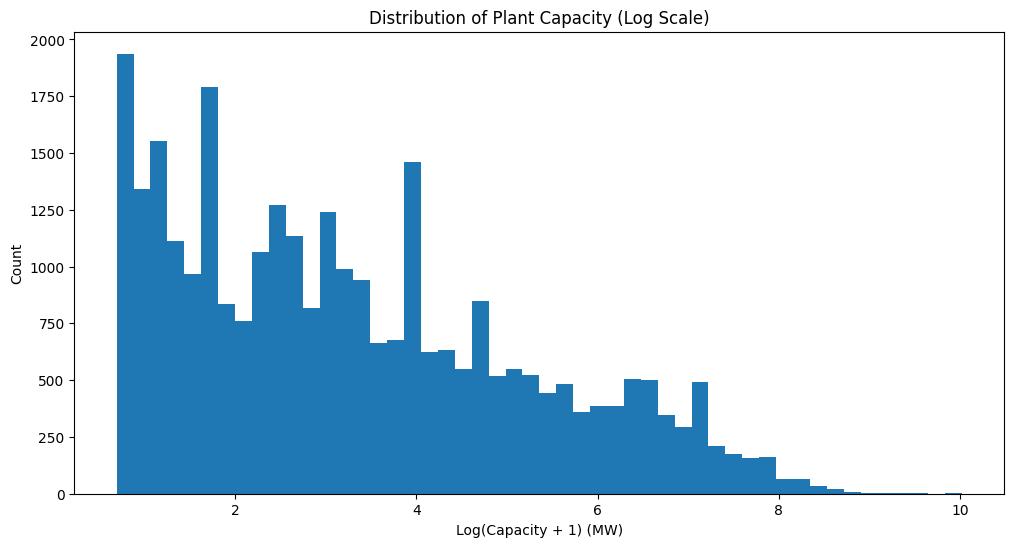

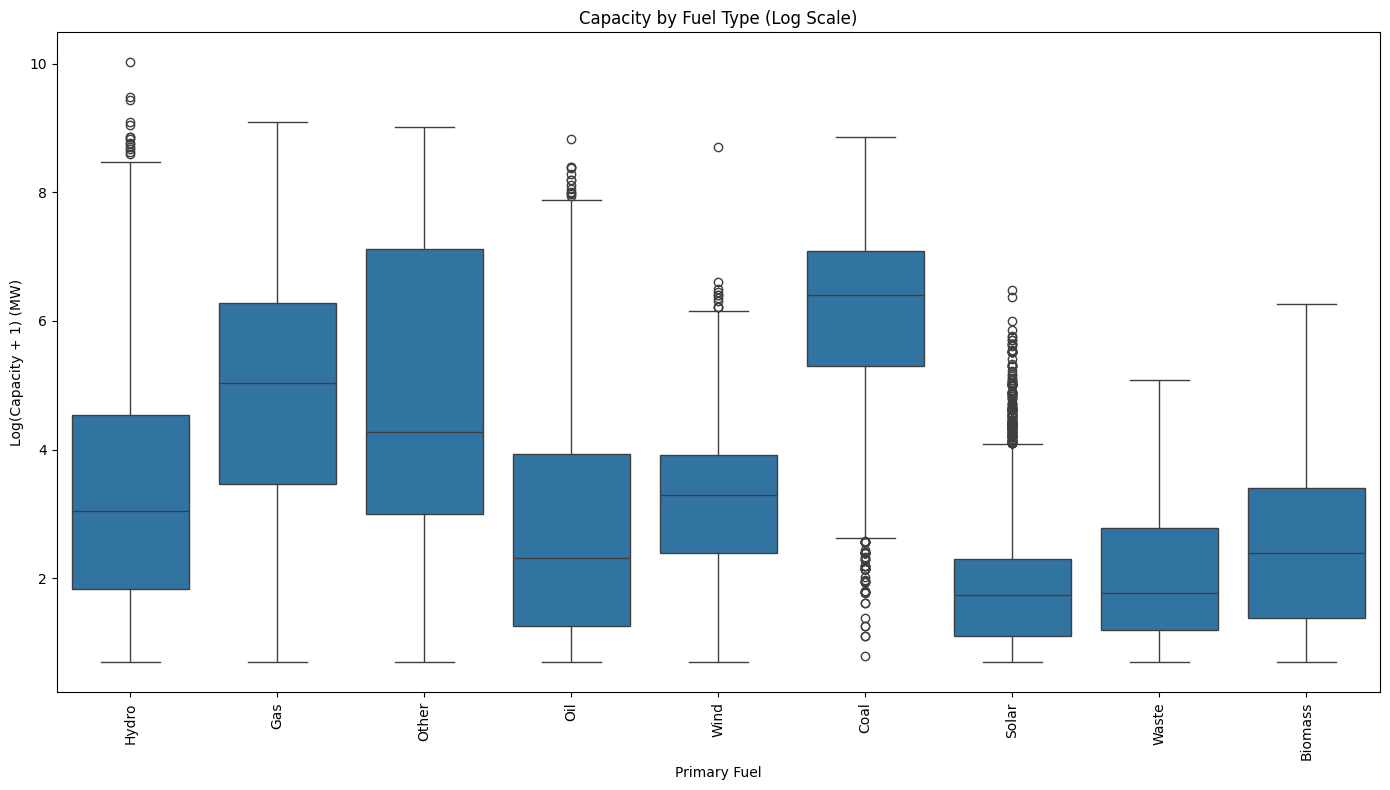

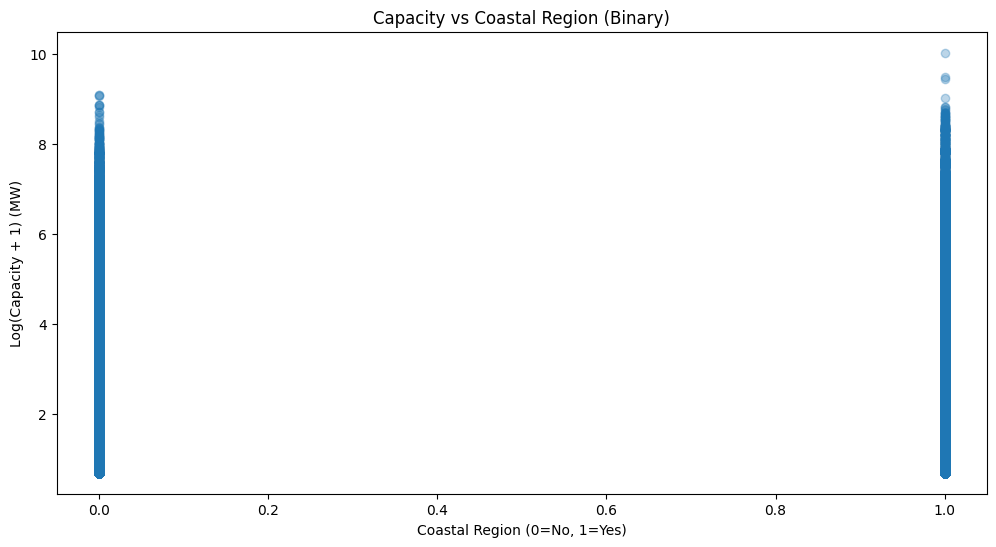

In [62]:
def main():
    np.random.seed(42)

    os.makedirs("plots", exist_ok=True)
    os.makedirs("data", exist_ok=True)

    experiment_name = f"Power_Plant_Capacity_Prediction_{datetime.now().strftime('%Y%m%d')}"
    mlflow.set_experiment(experiment_name)

    print(f"Starting Power Plant Capacity Prediction Experiment: {experiment_name}")
    print("=" * 80)

    print("\nStep 1: Loading and preparing data...")
    file_path = "/content/global_power_plant_database.csv"

    try:
        df = load_and_prepare_data(file_path)
        print("Data preparation successful!")
    except Exception as e:
        print(f"Error in data preparation: {str(e)}")
        return

    print("\nStep 2: Preparing data for modeling...")
    try:
        X_train, X_test, y_train, y_test = prepare_for_modeling(df)
        print("Data split successful!")
    except Exception as e:
        print(f"Error in preparing data for modeling: {str(e)}")
        return
    print("\nStep 3: Running machine learning experiments...")

    print(df.columns)
    run_power_plant_experiments(df)

    print("\nStep 4: Experiment summary")
    print("-" * 80)
    print("All models have been trained and evaluated.")
    print("Results are logged in MLflow and can be viewed with the MLflow UI.")
    print("You can access MLflow tracking information in the mlruns directory.")
    print("-" * 80)
    print("Top performing models will be ranked by RMSE and R² scores.")
    print("The neural network and ensemble methods are expected to perform well on this task.")
    print("=" * 80)

if __name__ == "__main__":
    main()